In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import functools as ft
from tools import helpers as h
from copy import copy

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import OrderedDict
from sklearn.preprocessing import Normalizer

%matplotlib inline

In [2]:
louv = pd.read_csv('../data/cluster/louvain_clusters.txt', index_col=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../data/cluster/louvain_small_clusters.txt', index_col=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


In [3]:
hgnc_mapper = h.fetch_hgnc_mapper()

In [4]:
# initial target list -- not for linear programming
klaeger = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

# a number of drugs have very similar targets listed in the same row
# we parse to separate these out 
double_drug_targets = klaeger[klaeger['Target'].apply(lambda x: ';' in x)]

# get the first and second gene
first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

# fix the double targets
repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
klaeger = klaeger.drop(double_drug_targets.index).append(repaired_double_targets, sort=False)

# filter to only hgnc keys
klaeger = klaeger[klaeger.Target.isin(hgnc_mapper.keys())]

# convert to hgnc
klaeger.Target = klaeger.Target.apply(lambda x: hgnc_mapper[x])

# filter to our kinases
klaeger = klaeger[klaeger.Target.isin(set(louv.index))]

# save total drug list information
drug_list = list(sorted(set(klaeger.Drug)))
print(len(drug_list), ' drugs present for our analysis')

# sort columns
klaeger = klaeger[['Target', 'Drug', 'At', 'CATDS']]

klaeger['Drug'] = [x.lower().replace('-', '') for x in klaeger.Drug]
klaeger.head()

217  drugs present for our analysis


,Target,Drug,At,CATDS
0,AURKA,mk5108,0.120921,0.657165
1,CHEK1,pf477736,0.243725,0.733257
2,FLT3,dovitinib,0.265240,0.860803
4,MET,capmatinib,0.337514,1.000000
5,MAPKAPK2,vx702,0.342705,0.743594


In [5]:
klaeger_drugs = set(klaeger.Drug)
print(len(klaeger_drugs), 'drugs in the Klaeger 2017 Science Paper with known targets')

217 drugs in the Klaeger 2017 Science Paper with known targets


### Klaeger All hits data (4-cell line mix)

In [6]:
allhits = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 2 Target Lists.xlsx', sheet_name='Kinobeads')

allhits_double_drug_targets = allhits[allhits['Gene Name'].apply(lambda x: ';' in x)]

# get the first and second gene
allhits_first_genes = allhits_double_drug_targets['Gene Name'].apply(lambda x: x.split(';')[0])
allhits_second_genes = allhits_double_drug_targets['Gene Name'].apply(lambda x: x.split(';')[1])

# fix the double targets
allhits_repaired_double_targets = allhits_double_drug_targets.drop('Gene Name', axis=1).assign(**{'Gene Name':allhits_first_genes})
allhits_repaired_double_targets = allhits_repaired_double_targets.append(allhits_double_drug_targets.drop('Gene Name', axis=1).assign(**{'Gene Name':allhits_second_genes})) 
allhits = allhits.drop(allhits_double_drug_targets.index).append(allhits_repaired_double_targets, sort=False)

# filter to only hgnc keys
allhits = allhits[allhits['Gene Name'].isin(hgnc_mapper.keys())]

# convert to hgnc
allhits['Gene Name'] = allhits['Gene Name'].apply(lambda x: hgnc_mapper[x])

# filter to our kinases
allhits = allhits[allhits['Gene Name'].isin(set(louv.index))]

# lower drug names
allhits['Drug'] = [x.lower().replace('-', '') for x in allhits.Drug]

allhits.head()

,Drug,Lysate,Beads,Gene Name,Relative Intensity DMSO,Relative Intensity 3 nM,Relative Intensity 10 nM,Relative Intensity 30 nM,Relative Intensity 100 nM,Relative Intensity 300 nM,...,Bottom,Top,Inflection,EC50,EC50 Standard Error,Correction Factor,Apparent Kd,R2,BIC,Target Classification
0,abemaciclib,4 cell line mix,Kinobeads,AAK1,1,0.905556,0.791054,0.738292,0.639565,0.323354,...,0.009092,0.957905,151.288760,151.288760,45.696999,0.673073,101.828368,0.985386,-20.503519,High confidence
1,abemaciclib,4 cell line mix,Kinobeads,ADCK1,1,1.045974,0.869866,1.141565,0.000000,0.000000,...,-0.001200,1.014355,63.935536,63.935536,68.832970,0.622595,39.805937,0.983520,-12.606135,High confidence
2,abemaciclib,4 cell line mix,Kinobeads,BMP2K,1,1.101696,1.012297,1.087891,0.973740,0.863230,...,-1.003278,1.034558,84774.108960,84774.108960,217756.243215,0.660952,56031.642989,0.937247,-15.330485,High confidence
3,abemaciclib,4 cell line mix,Kinobeads,CAMK2D,1,0.894551,0.984481,0.900583,0.440384,0.178266,...,0.018690,0.972850,95.373379,95.373379,12.131433,0.203913,19.447883,0.992088,-22.486948,High confidence
4,abemaciclib,4 cell line mix,Kinobeads,CAMK2G,1,1.125435,1.565245,1.236451,0.315507,0.139777,...,0.043265,1.232332,82.363844,82.363844,NaN,0.217204,17.889794,0.939239,1.734623,High confidence


In [7]:
len(set(allhits.Drug))

220

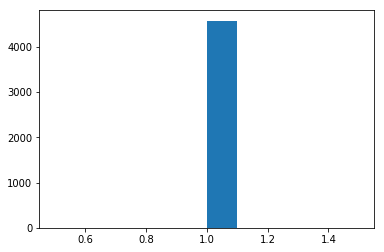

In [8]:
plt.hist(allhits['Relative Intensity DMSO'])
plt.show()

In [9]:
raw_conc_data = allhits[['Drug', 'Gene Name'] + [x for x in allhits.columns if 'Relative Intensity' in x and 'DMSO' not in x]]
raw_conc_data.head()

,Drug,Gene Name,Relative Intensity 3 nM,Relative Intensity 10 nM,Relative Intensity 30 nM,Relative Intensity 100 nM,Relative Intensity 300 nM,Relative Intensity 1000 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
0,abemaciclib,AAK1,0.905556,0.791054,0.738292,0.639565,0.323354,0.181984,0.063421,0.057103
1,abemaciclib,ADCK1,1.045974,0.869866,1.141565,0.000000,0.000000,0.000000,0.000000,0.000000
2,abemaciclib,BMP2K,1.101696,1.012297,1.087891,0.973740,0.863230,0.885498,0.862572,0.313434
3,abemaciclib,CAMK2D,0.894551,0.984481,0.900583,0.440384,0.178266,0.021331,0.004220,0.017424
4,abemaciclib,CAMK2G,1.125435,1.565245,1.236451,0.315507,0.139777,0.013431,0.005382,0.017473


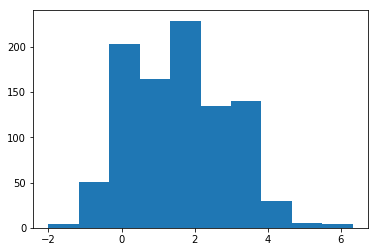

In [110]:
plt.hist(agg.sample(frac=.1)['GR50'])
plt.show()

In [58]:
from numba import jit

#@jit()
def gr(conc, GRinf, GR50, GR_Hill_Coeff):
    return GRinf + np.divide(1- GRinf, 1 + np.power(np.divide(conc,GR50+1.e-20), GR_Hill_Coeff)+1.e-20)

In [69]:

def extract_metrics(df, molecule):
    # look for the molecule in the dataframe and extract the relevant items
    return df[df['molecule']==molecule]

In [70]:
'''temp_row = agg[(agg['molecule']=='at7519') & (agg['cellline']=='bt20')]
temp_gr50, temp_grinf, temp_grhill = temp_row[['GR50', 'GRinf', 'GR_Hill_Coeff']].values[0]'''

"temp_row = agg[(agg['molecule']=='at7519') & (agg['cellline']=='bt20')]\ntemp_gr50, temp_grinf, temp_grhill = temp_row[['GR50', 'GRinf', 'GR_Hill_Coeff']].values[0]"

In [66]:
'''gr(.01, temp_grinf, temp_gr50, temp_grhill)'''

0.9711585004524448

## See what molecules we can predict

In [11]:
agg = pd.read_csv('../data/modelInputs/input_grMetrics.tsv', sep='\t', header=0, index_col=None)

# filter to high r2 values
agg = agg[agg['GR_r2'] > .6]
agg.head()

,molecule,cellline,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
0,seliciclib,bt20,1.898774,0.194160,-1.00000,1.17820,0.17548,0.97227,0.0,0.0,1.0
1,a443654,bt20,0.051675,-0.492210,-0.63357,0.55758,1.00120,0.98743,0.0,0.0,1.0
3,at7519,bt20,0.186015,-0.401780,-0.40563,1.32240,0.86351,0.99936,0.0,0.0,1.0
4,azd5438,bt20,0.219866,-0.354640,-0.44610,0.79155,0.74810,0.99091,0.0,0.0,1.0
5,azd6482,bt20,0.827110,-0.081485,-0.54825,0.76277,0.42682,0.99881,0.0,0.0,1.0


In [114]:
# filter out nans
agg = agg[agg['GR50'] > 0]

## Note: the concentration inputs to gr calculator are micromolar

In [12]:
display(len(set(agg.molecule)& klaeger_drugs))
display(len(set(agg.molecule) & set(raw_conc_data.Drug)))

82

82

In [13]:
common_drugs = set(agg.molecule) & set(raw_conc_data.Drug)

### Filter to shared molecules

In [14]:
agg = agg[agg.molecule.isin(common_drugs)]
conc_data = raw_conc_data[raw_conc_data.Drug.isin(common_drugs)]

In [15]:
conc_data.head()

,Drug,Gene Name,Relative Intensity 3 nM,Relative Intensity 10 nM,Relative Intensity 30 nM,Relative Intensity 100 nM,Relative Intensity 300 nM,Relative Intensity 1000 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
116,afatinib,ADK,1.101254,1.486669,1.077845,1.114982,1.371766,1.106729,0.704253,0.000000
117,afatinib,EGFR,0.501030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
118,afatinib,GAK,1.105101,1.006153,1.025470,1.015382,1.002719,0.931173,0.625327,0.203584
120,afatinib,MAPK11,0.929032,1.081225,1.307298,1.440432,1.221845,0.860905,0.741909,0.000000
121,afatinib,MAPK14,1.098158,1.151929,1.147222,1.065271,0.968552,0.814896,0.503224,0.171431


### Examine distributions/missing observations

In [16]:
from collections import Counter
c = Counter(conc_data.Drug)
display( c.most_common(20) )

[('lestaurtinib', 86),
 ('pf3758309', 84),
 ('sunitinib', 72),
 ('azd7762', 69),
 ('dasatinib', 69),
 ('pf477736', 64),
 ('dovitinib', 54),
 ('kw2449', 52),
 ('dabrafenib', 49),
 ('pf562271', 48),
 ('bosutinib', 46),
 ('saracatinib', 44),
 ('nintedanib', 42),
 ('foretinib', 39),
 ('silmitasertib', 39),
 ('gsk1070916', 36),
 ('momelotinib', 34),
 ('alvocidib', 32),
 ('gsk690693', 31),
 ('ruxolitinib', 31)]

In [17]:
c= Counter(conc_data['Gene Name'])
display( c.most_common(20) )

[('RET', 36),
 ('ABL1', 27),
 ('FLT3', 27),
 ('BMP2K', 24),
 ('STK10', 24),
 ('CSNK2A2', 23),
 ('PDGFRB', 23),
 ('AURKB', 22),
 ('MAP4K5', 22),
 ('DDR1', 22),
 ('CSNK2A1', 22),
 ('ABL2', 21),
 ('GAK', 20),
 ('SLK', 20),
 ('MAP2K5', 20),
 ('RIPK2', 20),
 ('DDR2', 19),
 ('AAK1', 18),
 ('RIPK3', 18),
 ('HCK', 17)]

In [18]:
conc_data.shape

(1771, 10)

### Melt the concentrations

In [19]:
partial_obs = conc_data.melt(id_vars=['Drug', 'Gene Name'], value_name='Intensity')
partial_obs.head()

,Drug,Gene Name,variable,Intensity
0,afatinib,ADK,Relative Intensity 3 nM,1.101254
1,afatinib,EGFR,Relative Intensity 3 nM,0.501030
2,afatinib,GAK,Relative Intensity 3 nM,1.105101
3,afatinib,MAPK11,Relative Intensity 3 nM,0.929032
4,afatinib,MAPK14,Relative Intensity 3 nM,1.098158


### Construct the full obsevation matrix (with ones)

In [20]:
remaining_drugs = list(partial_obs.Drug.unique())
remaining_genes = list(partial_obs['Gene Name'].unique())
intensities_unique = list(partial_obs['variable'].unique())

complete_combos = list(it.product(remaining_drugs, remaining_genes, intensities_unique))
print(len(complete_combos))

152848


In [21]:
complete_obs = pd.DataFrame(complete_combos)
complete_obs[4] = 1
complete_obs.columns=['Drug','Gene Name','Concentration','Intensity']
complete_obs.sort_values(by=['Concentration', 'Drug'], inplace=True)
complete_obs.head(10)

,Drug,Gene Name,Concentration,Intensity
1,afatinib,ADK,Relative Intensity 10 nM,1
9,afatinib,EGFR,Relative Intensity 10 nM,1
17,afatinib,GAK,Relative Intensity 10 nM,1
25,afatinib,MAPK11,Relative Intensity 10 nM,1
33,afatinib,MAPK14,Relative Intensity 10 nM,1
41,afatinib,MAPK9,Relative Intensity 10 nM,1
49,afatinib,MAPKAPK2,Relative Intensity 10 nM,1
57,afatinib,MET,Relative Intensity 10 nM,1
65,afatinib,MYLK,Relative Intensity 10 nM,1
73,afatinib,PHKG2,Relative Intensity 10 nM,1


In [22]:
# fill the observations with known data
# we use a multiindex to slice quickly
complete_obs = complete_obs.groupby(['Drug', 'Gene Name', 'Concentration'])['Intensity'].sum()
partial_obs = partial_obs.groupby(['Drug', 'Gene Name', 'variable'])['Intensity'].sum()

In [23]:
for observation in partial_obs.index:
    complete_obs.loc[observation] = partial_obs[observation]
    
complete_obs = complete_obs.reset_index()
partial_obs = partial_obs.reset_index()

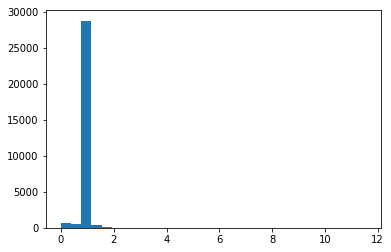

In [24]:
plt.hist(complete_obs.sample(frac=.2)['Intensity'], bins=30)
plt.show()

In [25]:
# print the 10 smallest values of intensity to show a good epsilon
list(sorted(complete_obs['Intensity'][complete_obs['Intensity']>0]))[:20]

# extract min
min_observed = min(complete_obs['Intensity'][complete_obs['Intensity']>0])

In [26]:
# min_cutter assumes machine precision half of smallest
min_cutter = 2
complete_obs['Intensity'][complete_obs['Intensity'] == 0] = min_observed/min_cutter

/Users/isrobson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# log2 transform the data
complete_obs['Intensity'] = np.log2(complete_obs['Intensity'].values)
complete_obs.head()

,Drug,Gene Name,Concentration,Intensity
0,afatinib,AAK1,Relative Intensity 10 nM,0.0
1,afatinib,AAK1,Relative Intensity 100 nM,0.0
2,afatinib,AAK1,Relative Intensity 1000 nM,0.0
3,afatinib,AAK1,Relative Intensity 3 nM,0.0
4,afatinib,AAK1,Relative Intensity 30 nM,0.0


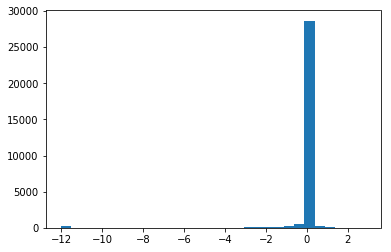

In [28]:
plt.hist(complete_obs.sample(frac=.2)['Intensity'], bins=30)
plt.show()

### Interpolate the growth at each concentration

In [73]:
# first, convert concentration to micromolar (numeric)
complete_obs['Concentration'] = complete_obs['Concentration'].apply(lambda x: float(x.split(' ')[2]))/1000
complete_obs.head()

,Drug,Gene Name,Concentration,Intensity
0,afatinib,AAK1,0.010,0.0
1,afatinib,AAK1,0.100,0.0
2,afatinib,AAK1,1.000,0.0
3,afatinib,AAK1,0.003,0.0
4,afatinib,AAK1,0.030,0.0


In [83]:
drug_gene_combos = list(zip(complete_obs.groupby(['Drug', 'Gene Name']).agg(np.sum).reset_index().Drug, complete_obs.groupby(['Drug', 'Gene Name']).agg(np.sum).reset_index()['Gene Name']))
drug_gene_combos[:5]

[('afatinib', 'AAK1'),
 ('afatinib', 'ABL1'),
 ('afatinib', 'ABL2'),
 ('afatinib', 'ACVR1'),
 ('afatinib', 'ACVR1B')]

In [117]:
from time import time

### This should not be looking at genes

In [121]:
s = time()
interpolated_data = {}
concentrations = list(complete_obs.Concentration.unique())

count = 0
# loop through the observations and create new data
for d, g in drug_gene_combos:
    # select observed data
    gr_data_to_interpolate_with = extract_metrics(agg, d)
    
    for i, gr_row in gr_data_to_interpolate_with.iterrows():
        local_gr50, local_grinf, local_grhill, local_cellline = list(gr_row[['GR50', 'GRinf', 'GR_Hill_Coeff', 'cellline']].values)
        
        for c in concentrations:
            interpolated_data[(d, g, local_cellline, c)] = gr(c, local_grinf, local_gr50, local_grhill)
        
    if count % 1000 == 0: 
        print('Done with combo '  + str(count) + '/' + str(len(drug_gene_combos)))
    count +=1
print(time()-s)

Done with combo 0/19106
Done with combo 1000/19106
Done with combo 2000/19106
Done with combo 3000/19106
Done with combo 4000/19106
Done with combo 5000/19106
Done with combo 6000/19106
Done with combo 7000/19106
Done with combo 8000/19106
Done with combo 9000/19106
Done with combo 10000/19106
Done with combo 11000/19106
Done with combo 12000/19106
Done with combo 13000/19106
Done with combo 14000/19106
Done with combo 15000/19106
Done with combo 16000/19106
Done with combo 17000/19106
Done with combo 18000/19106
Done with combo 19000/19106


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'

In [123]:
interpolated_df = pd.Series(interpolated_data)
interpolated_df.head()

afatinib  AAK1  hs578t  0.010    0.999997
                        0.100    0.998848
                        1.000    0.674671
                        0.003    1.000000
                        0.030    0.999945
dtype: float64

In [124]:
interpolated_df = pd.DataFrame(interpolated_df)
interpolated_df.head()

0
afatinib AAK1 hs578t 0.010  0.999997
                     0.100  0.998848
                     1.000  0.674671
                     0.003  1.000000
                     0.030  0.999945

In [126]:
interpolated_df = interpolated_df.reset_index()
interpolated_df.columns = ['Drug', 'Gene', 'Cellline', 'Concentration', 'Growth']

In [129]:
interpolated_df.head()

,Drug,Gene,Cellline,Concentration,Growth
0,afatinib,AAK1,hs578t,0.010,0.999997
1,afatinib,AAK1,hs578t,0.100,0.998848
2,afatinib,AAK1,hs578t,1.000,0.674671
3,afatinib,AAK1,hs578t,0.003,1.000000
4,afatinib,AAK1,hs578t,0.030,0.999945


In [131]:
interpolated_df['idx'] = interpolated_df['Drug'] + interpolated_df['Gene'] + interpolated_df['Concentration'].apply(str)
complete_obs['idx'] = complete_obs['Drug'] + complete_obs['Gene Name'] + complete_obs['Concentration'].apply(str)

In [137]:
df = interpolated_df.merge(complete_obs, how='left', on='idx')

In [140]:
df = df[['Drug_x', 'Gene', 'Cellline', 'Concentration_x', 'Intensity', 'Growth']]
df.columns = ['Drug', 'Gene', 'Cellline', 'Concentration', 'Intensity', 'Growth']
df.head()

,Drug,Gene,Cellline,Concentration,Intensity,Growth
0,afatinib,AAK1,hs578t,0.010,0.0,0.999997
1,afatinib,AAK1,hs578t,0.100,0.0,0.998848
2,afatinib,AAK1,hs578t,1.000,0.0,0.674671
3,afatinib,AAK1,hs578t,0.003,0.0,1.000000
4,afatinib,AAK1,hs578t,0.030,0.0,0.999945


In [146]:
t = df.pivot_table(index=['Drug', 'Cellline', 'Growth', 'Concentration'], columns='Gene')

In [154]:
gene_cols = t.head().reset_index().columns.get_level_values(1).tolist()
gene_cols[:4] = ['Drug', 'Gene', 'Cellline', 'Concentration']

In [158]:
t = t.reset_index()
t.columns = gene_cols

In [162]:
t.shape

(62368, 237)

In [163]:
t.to_csv('../data/interpolated_conc_df.csv', index=False)